<a href="https://colab.research.google.com/github/hersan19/Taller_IM_PG/blob/main/taller_IM_PG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lectura de funciones desde Github
La siguiente celda carga a la máquina virtual el archivo "function_set.py" el cual contiene las funciones a utilizar para el procesamiento de imágenes. 
El archivo se lee desde el repositorio del tutorial

In [ ]:
user = "hersan19"
repo = "ENC2022-PI-PG"
src_dir = "blob"
pyfile = "function_set.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{pyfile}"
!wget --no-cache --backups=0 {url}

--2022-08-24 18:43:51--  https://raw.githubusercontent.com/hersan19/ENC2022-PI-PG/main/function_set.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9589 (9.4K) [text/plain]
Saving to: ‘function_set.py.1’

function_set.py.1   100%[===================>]   9.36K  --.-KB/s    in 0s      

2022-08-24 18:43:51 (106 MB/s) - ‘function_set.py.1’ saved [9589/9589]



# Instalación de bibiliotecas a utilizar
Se instalan bibliotecas que se utilizarán para el ejercicio. 

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install deap
!pip install kornia

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Bibliotecas
Se importan las bibliotecas a utilzar para el manejo de imágenes, clasificadores y programación genética 

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import kornia as K
#Bibliotecas para gráficos
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
# Bibliotecas para el procesamiento de imágenes
import numpy as np 
import skimage
import pandas as pd 
# Bibliotecas para el cómputo evolutivo
import operator 
import math
import random
from deap import base, creator, tools, gp
#Bilbiotecas para datasets
from imblearn.under_sampling import RandomUnderSampler
#Bibliotecas para clasificadores
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import torch.nn.functional as F
import torch.nn as nn
#Bibliotecas para gp
import networkx as nx
import pygraphviz as pgv
import function_set as fs
from deap import algorithms
import seaborn as sns


from collections import Counter
import random
random.seed(23)
np.random.seed(23)

# Conjuntos de datos
Se agregan los conjuntos de datos a utilizar. MNIST y FashionMNIST

In [ ]:
#Función para descargar el conjunto de datos en formato tensor
def get_data_tensor(dataset):
  transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Grayscale(1),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     #transforms.Normalize((0.5,), (0.5,), (0.5))
     ])
  
  data = {}
   
  #MNIST (60,000 train + 10,000 test)
  if dataset == 'MNIST':
    batch_size = 60000
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    dataiter = iter(trainloader)
    images_train, labels_train = dataiter.next() 
    
    batch_size = 10000
    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
    dataiter = iter(testloader)
    images_test, labels_test = dataiter.next()
 
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
  
  #FMNIST (60,000 train + 10,000 test)
  elif dataset == "FMNIST":
    batch_size = 60000
    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    dataiter = iter(trainloader)
    images_train, labels_train = dataiter.next()
    
    batch_size = 10000
    testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
    dataiter = iter(testloader)
    images_test, labels_test = dataiter.next()

    classes = ('t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle-boot')

  data["train_images"] = images_train
  data["train_labels"] = labels_train
    
  data["test_images"] = images_test
  data["test_labels"] = labels_test

  return data, classes

In [ ]:
#Obtiene datos en formato tensor
# data, classes = get_data_tensor('MNIST')
data, classes = get_data_tensor('FMNIST')

train_images = data["train_images"]
train_labels = data["train_labels"]

test_images = data["test_images"]
test_labels = data["test_labels"]

In [ ]:
#Función para obtener un conjunto de datos balanceado en clases
def get_data_balanced(images, labels, no_examples_per_class):
  #Conforma vector de píxeles
  images_t = images.flatten(start_dim=1)

  #Genera diccionarcio
  def mk_dict_balance(no_examples, no_classes):
    dic={}
    for i in range(no_classes):
      dic[i]=no_examples
    return dic
  
  #A partir de un vector devuelve una imagen de tamaño "size como tupla"
  def vector2img(vector, size):
    ch=3 if vector.shape[1]%3==0 else 1
    return vector.view(len(vector), ch, size[0], size[1])

  #Genera dataset balanceado
  balanced = mk_dict_balance(no_examples_per_class, 10)
  under_sampler = RandomUnderSampler(random_state=42, sampling_strategy=balanced)#"auto"
  X_res, y_res = under_sampler.fit_resample(images_t, labels)
  #print(Counter(y_res))

  #Recupera formato de tensor [B C H W]
  size = (images.shape[2], images.shape[3])
  images_balanced = vector2img(torch.from_numpy(X_res), size)
  labels_balanced = torch.from_numpy(y_res)

  return images_balanced, labels_balanced

In [ ]:
#Obtiene un dataset balanceado: 80 imágenes por clase para entrenamiento y 20 por clase para prueba
train_images, train_labels = get_data_balanced(train_images, train_labels, 80)
test_images, test_labels = get_data_balanced(test_images, test_labels, 20)

In [ ]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

(torch.Size([800, 1, 28, 28]),
 torch.Size([800]),
 torch.Size([200, 1, 28, 28]),
 torch.Size([200]))

# Muestra imágenes
Se crea una función que permite visualizar los datos almacenados lso tensores *train_images* y *test_images*

In [ ]:
#Funciones para mostrar una imagen
def vector2img(vector, size):
  ch=3 if vector.shape[1]%3==0 else 1
  return vector.view(len(vector), ch, size[0], size[1])

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Tomamos 40 imágenes del conjunto de entrenamiento y las mostramos en un *grid* de 5 x 8

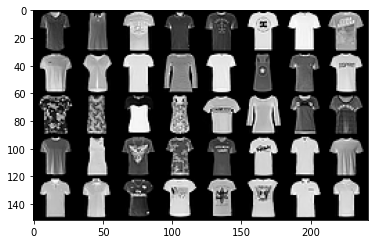

In [ ]:
grid = torchvision.utils.make_grid(train_images[:40], nrow = 8, padding = 2)
imshow(grid)

Muestra una sola imagen

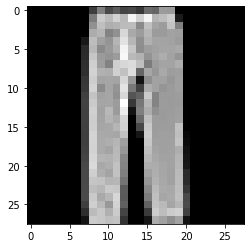

trouser


In [ ]:
# Muestra un ejemplo de la imagen que compone el conjunto de datos
idx=100
grid=torchvision.utils.make_grid(train_images[idx,:,:,:])
imshow(grid)
print(classes[train_labels[idx]])

# Conjunto de funciones
La biblioteca Kornia ofrece un conjunto de funciones y operaciones para resolver problemas de visión por computadora, redes neuronales con soporte para el cómputo en tarjetas gráficas.
Para más información: https://github.com/kornia/kornia

Las funciones consideradas se encuentran en el archivo "function_set.py". Se compone por las siguientes funciones.

*   Funciones morfológicas
>* Erosión
>* Dilatación
>* Apertura o *Opening*
>* Cierre o *Closing*
*   Detección de bordes
>* Sobel
>* LaPlaciano
>* Gradiente
*   Funciones aritméticas
>* Suma (2 o 3 entradas)
>* Raíz cuadrada
*   Filtrado y transformaciones de intensidad
>* Ecualización de histograma
>* Ajuste de brillo
>* Gaussiano

Se muestra a continuación el efecto que se tiene al aplicar dichas funciones.


## Funciones morfológicas
Selecciona un conjunto de imágenes del conjunto de entrenamieto almacenado en el tensor con dimensiones [B, C, H, W], donde B se refiere al tamaño del lote, C al número de canales, H y W a la altura y ancho de las imágenes, respectivamente.

In [ ]:
images = train_images.clone()

Se aplican las funciones morfológicas de erosión, dilatación, apertura y cierre

In [ ]:
images_ero = fs.Erosion(images)
images_dil = fs.Dilation(images)
images_ope = fs.Opening(images)
images_clo = fs.Closing(images)

y se muestra el efecto de aplicar las funciones morfológicas a un conjunto de imágenes en particular:

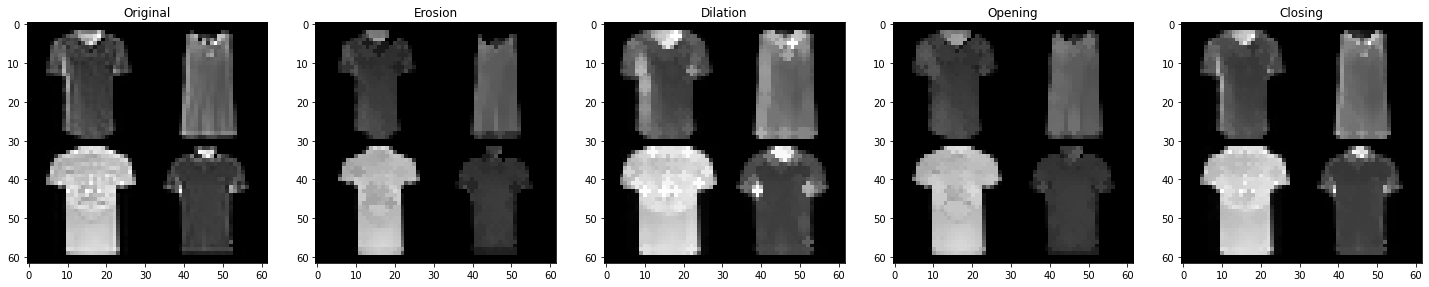

In [ ]:
idx=4
morphologicals = [images_ero, images_dil, images_ope, images_clo]
grids=[torchvision.utils.make_grid(morph[:idx], nrow = idx//2, padding = 2) for morph in morphologicals]
grids.insert(0, torchvision.utils.make_grid(images[:idx], nrow = idx//2, padding = 2))
grids=[np.transpose(grid.numpy(), (1,2,0)) for grid in grids]
titles=['Original', 'Erosion', 'Dilation', 'Opening', 'Closing']

f = plt.figure(figsize=(25,25))
for i in range(len(titles)):
  f.add_subplot(1, len(titles), i+1)
  plt.title(titles[i])
  plt.imshow(grids[i])

## Funciones de detección de bordes
Se aplican las funciones de detección de bordes: Sobel, LaPlaciano y Gradiente al conjunto de imágenes.

In [ ]:
images_sobel = fs.Sobel(images)
images_lapl = fs.LaPlacian(images)
images_grad = fs.Gradient(images)

Nuevamente, se muestra el efecto de aplicar dichas funciones al conjunto de datos

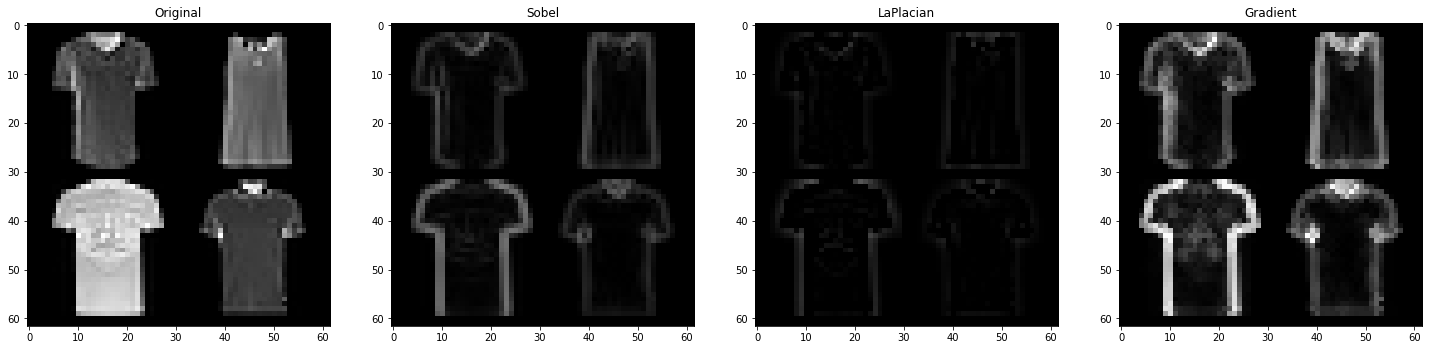

In [ ]:
idx=4
edges = [images_sobel, images_lapl, images_grad]
grids=[torchvision.utils.make_grid(edge[:idx], nrow = idx//2, padding = 2) for edge in edges]
grids.insert(0, torchvision.utils.make_grid(images[:idx], nrow = idx//2, padding = 2))
grids=[np.transpose(grid.numpy(), (1,2,0)) for grid in grids]
titles=['Original', 'Sobel', 'LaPlacian', 'Gradient']

f = plt.figure(figsize=(25,25))
for i in range(len(titles)):
  f.add_subplot(1, len(titles), i+1)
  plt.title(titles[i])
  plt.imshow(grids[i])

## Funciones aritméticas
Se aplican las funciones artiméticas a un conjunto de imágenes. Se considera la función suma de aridad 2 y 3 y raíz cuadrada

In [ ]:
input1 = fs.Erosion(images)
input2 = fs.Opening(images)
input3 = fs.Sobel(images)
images_add2 = fs.suma_imgs2(input1, input2)
images_add3 = fs.suma_imgs3(input1, input2, input3)
images_sqrt = fs.sqrt(input3)

Se muestra el efecto de sumar 2 y 3 imágenes distintas entre sí. Además, la función de raíz cuadrada aplicada a la entrada 3, producto de aplicar el filtro Sobel.

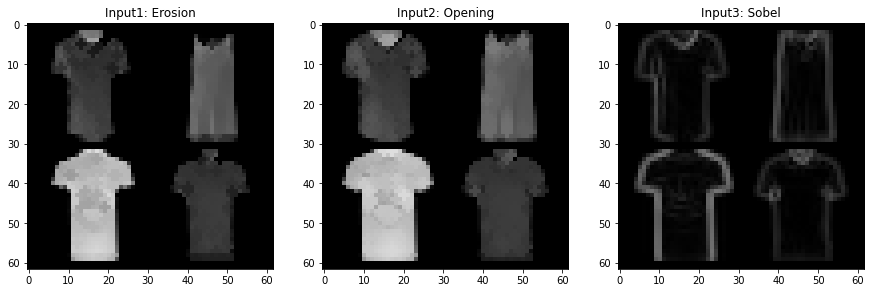

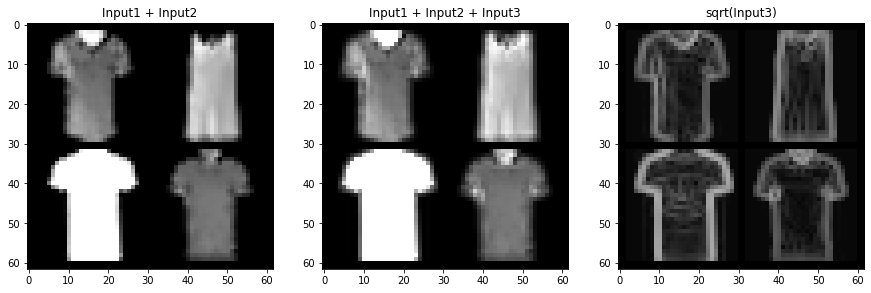

In [ ]:
idx=4
inputs=[input1, input2, input3]
arithms = [images_add2, images_add3, images_sqrt]
grids_inp=[torchvision.utils.make_grid(inp[:idx], nrow = idx//2, padding = 2) for inp in inputs]
grids=[torchvision.utils.make_grid(arithm[:idx], nrow = idx//2, padding = 2) for arithm in arithms]

# grids.insert(0, torchvision.utils.make_grid(images[:4], nrow = 2, padding = 2))
grids_inp=[np.transpose(inp.numpy(), (1,2,0)) for inp in grids_inp]
grids=[np.transpose(grid.numpy(), (1,2,0)) for grid in grids]
titles_inp=['Input1: Erosion','Input2: Opening','Input3: Sobel']
titles=['Input1 + Input2', 'Input1 + Input2 + Input3', 'sqrt(Input3)']

f = plt.figure(figsize=(15,15))
for i in range(len(titles)):
  f.add_subplot(1, len(titles), i+1)
  plt.title(titles_inp[i])
  plt.imshow(grids_inp[i])

f2 = plt.figure(figsize=(15,15))
for i in range(len(titles)):
  f2.add_subplot(1, len(titles), i+1)
  plt.title(titles[i])
  plt.imshow(grids[i])

# Clasificadores
Se declararn los clasificadores a utilizar:
*   KNN
*   Árbol de decisión
*   Máquina de soporte vectorial
*   Multiperceptrón



In [ ]:
#Clasificador MultiPerceptron Pytorch
class MLP(nn.Module):
  def __init__(self, in_channels, hidden_channels, 
               no_epochs, lr):
    super(MLP, self).__init__()
    self.mlp = torchvision.ops.MLP(in_channels, hidden_channels, activation_layer=torch.nn.ReLU)
    self.no_epochs=no_epochs
    self.lr=lr

  def forward(self, x):
    x = self.mlp(x)
    return x

In [ ]:
#Clasificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

names = [
    "KNN",
    "Decision Tree",
    "MLP",
    "SVM"
]

classifiers = [
    KNeighborsClassifier(1),
    DecisionTreeClassifier(max_depth=5),
    MLP(784,[200,200,10],
        no_epochs=200, lr=0.01),
    SVC(kernel="rbf")
]

clfs_names=dict(zip(names,classifiers))

# Programación Genética
La siguiente sección muesta la implementación un algoritmo evolutivo basado en PG con la librería DEAP. Para más información: https://github.com/deap/deap



## Conjunto de funciones y terminales
Se declara el conjunto de funciones y terminales.
Las funciones a utilizar se toman del script "function_set.py".
Dichas funciones se encargan de realizar el procesamiento digital del conjunto de imágenes. 

En total se encuentran 13 funciones. Las funciones utilizadas están basadas en la biblioteca Kornia. Cuenta con imágenes morfológicas, detectores de bordes, funciones de mejoramiento de imágenes y funciones aritméticas. Las funciones  aritméticas *sum2* y *sum3* fungen como constructores de características al combinar dos o tres mapas de características. 

In [ ]:
#Conjunto de funciones
pset = gp.PrimitiveSet("main", 1)

pset.addPrimitive(fs.Erosion, 1, "ero")
pset.addPrimitive(fs.Dilation, 1, "dil")
pset.addPrimitive(fs.Closing, 1, "clo")
pset.addPrimitive(fs.Opening, 1, "op")

pset.addPrimitive(fs.En_adbright, 1, "bright")
pset.addPrimitive(fs.En_equal, 1, "h_eq")

pset.addPrimitive(fs.suma_imgs2, 2, "sum2")
pset.addPrimitive(fs.suma_imgs3, 3, "sum3")
pset.addPrimitive(fs.sqrt,1,"sqrt")

pset.addPrimitive(fs.Sobel, 1, "sobel")
# pset.addPrimitive(fs.LaPlacian, 1, "laplace")
# pset.addPrimitive(fs.Gradient, 1, "grad")

#Conjunto de terminales
pset.renameArguments(ARG0='img')

## Toolbox de PG
La librería DEAP ofrece el módulo *base.Toolbox* que permite almacenar los operadores del proceso evolutivo. Por ejemplo, funciones que generan aleatoriamente una población, operadores de variación, mecanismos de selección y la función de evaluación. Para añadir funciones al *toolbox* se utiliza el método *register* que recibe el nombre de la función a almacenar y los parámetros que tendrá por default.

In [ ]:
toolbox = base.Toolbox()

## Árbol sintáctico generado con PG en DEAP
Dada la representaciónb arbolada de las soluciones, una de las ventajas de la PG es la **expresividad** de los individuos. Cada solución se muestra como una composición de los operadores que intervienen para generar una salida, facilitando así la tarea de *decodificación*. Esta composición de funciones puede representarse como un **árbol sintáctico** que toma como entrada una imagen. Un ejemplo de árbol sintáctico es el siguiente:


> *'op(h_eq(sum2(h_eq(img), op(img))))'*



La **biblioteca DEAP** ofrece un meta-constructor de clases que permite generar clases y sus atributos. Toma como parámetros el nombre de la clase, la clase base de la que toma herencia y los atributos declarados al generar cada instancia.

Para generar un individuo en este framework es necesario señalar el número de objetivos a optimizar y si se trata minimizarlos o maximizarlos. Con base en la clase *base.Fitness* se genera la clase *FitnessMax* que permite obtener una medida de calidad de las soluciones. Un problema de maximización mono-objetivo es señalado mediante el parámetro *weights* que es una una tupla que toma un valor de *(1.0)*. El número de elementos que componen la tupla representa la cantidad de objetivos a optimizar. El signo de cada elemento de la tupla indica si se trata de maximizar o minimizar cada objetivo; un signo negativo representa un problema de minimización, en caso contrario, se trata de un problema de maximización.

Una vez declarado el número de objetivos y el tipo de problema, los individuos se generan utilizando la clase *Individual* que asignan a cada árbol generado una aptitud, señalado mediante el parámetro *fitness* con una instancia de la clase *FitnessMax*.

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

La siguiente función permite visualizar el árbol correspondiente a los indivuduos generados por PG.

In [ ]:
#Función para graficar/visualizar el árbol
def plt_ind(inds, titles=[]):
  if len(titles)==0:
    titles=len(inds)*['']
  
  f = plt.figure()
  for i, ind in enumerate(inds):
    tree=gp.PrimitiveTree(ind)
    nodes, edges, labels = gp.graph(tree)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.nx_agraph.graphviz_layout(g, prog="dot")

    # plt.subplot(int('1'+str(len(inds))+str(i+1))).set_title(titles[i])
    f.add_subplot(1, len(titles), i+1)
    plt.title(titles[i])
    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)

    plt.axis('off')
  plt.show()
  return

In [ ]:
#Función para guardar los árboles generados
def save_ind(ind, name):
    tree=gp.PrimitiveTree(ind)
    nodes, edges, labels = gp.graph(tree)
    g = pgv.AGraph(directed=False)
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    g.layout(prog="dot")
    
    for i in nodes:
        n = g.get_node(i)
        n.attr["label"] = labels[i]   
    
    g.draw("./"+name+".png")
    return

Tomando el árbol sintáctico del ejemplo, podemos tener una representación explícita al graficarlo mediante la siguiente celda.

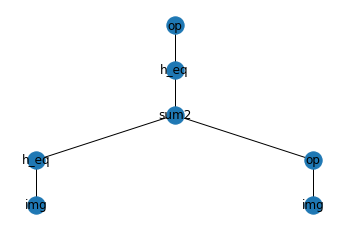

In [ ]:
syntax_tree = 'op(h_eq(sum2(h_eq(img), op(img))))'
pt = gp.PrimitiveTree.from_string(syntax_tree, pset)
ind = creator.Individual(pt)
plt_ind([ind])
save_ind(ind,'tree_example2')

Dos características importantes de los árboles generados son el **tamaño** y la **altura** de los árboles.


1.   **Tamaño**. Número de nodos que componen el árbol
2.   **Altura**. El número de aristas que hay que recorrer desde la raíz del árbol hasta el **nodo más profundo**.

In [ ]:
tamano = len(ind)
altura = ind.height
print(f'Árbol con tamaño = {tamano}  y altura = {altura}')

Árbol con tamaño = 7  y altura = 4


El efecto de aplicar la composición de funciones expresados en el árbol sintáctico se muestra en la siguiente celda. La instrucción *function = gp.compile(ind, pset)* permite obtener un objeto invocable, esto es, una instrucción que puede ser llamada como una función. Para obtener las características extraídas se utiliza la instrucción *out = function(images)* donde *images* representa el tensor que almacena el conjunto de imágenes de entrada.

In [ ]:
function = gp.compile(ind, pset=pset)
out = function(images)

La siguiente celca nos permite visualizar el efecto de aplicar las funciones expresadas por el árbol sintáctico. Se muestran las imágenes de entrada y de salida.

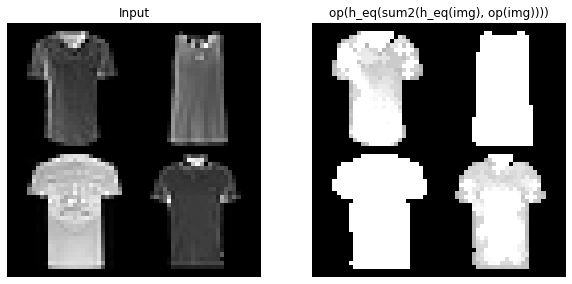

In [ ]:
inp_out=[images, out]
idx=4
grids=[torchvision.utils.make_grid(io[:idx], nrow = idx//2, padding = 2) for io in inp_out]
grids=[np.transpose(grid.numpy(), (1,2,0)) for grid in grids]
titles=['Input', syntax_tree]

f = plt.figure(figsize=(10,10))
for i in range(len(titles)):
  f.add_subplot(1, len(titles), i+1)
  plt.axis('off')
  plt.title(titles[i])
  plt.imshow(grids[i])

## Población inicial
Tal como en otro paradigmas evolutivos, la generación de la población generalmente se realiza de forma aleatoria. Para la generación de los árboles en PG existen tres métodos que toman en cuentra una cota mínima y máxima en la altura de los árboles. En DEAP estos métodos se encuentran implementados en el módulo *deap.gp*

### 1.   *Full*
> Permite generar árboles donde todas las hojas o nodos terminales se encuentran a la misma profundidad. Los nodos son *seleccionados del conjunto de funciones* hasta alcanzar una altura máxima


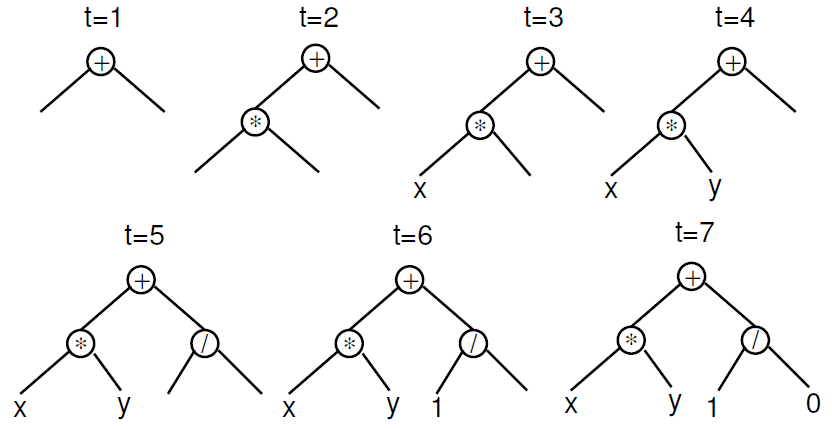

### 2.   *Grow*
> Permite obtener árboles con altura y tamaño más diverso. Los nodos son *seleccionados del conjunto de funciones y terminales* hasta alcanzar una altura máxima.


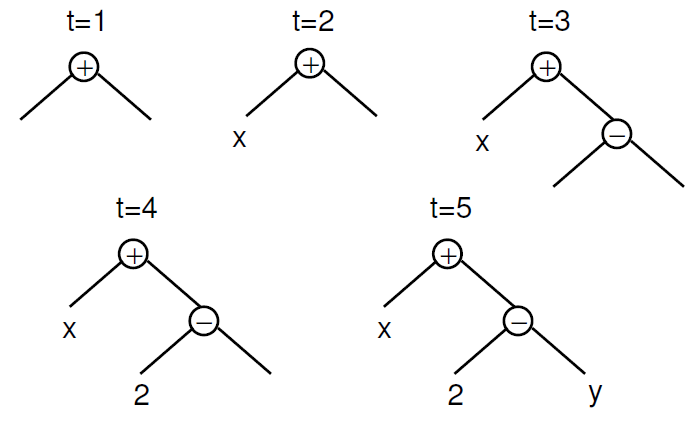

### 3.   *Ramped Half-and-half*
> La mitad de la población es generada con el método *Full* y la otra mitad con el método *Grow*.

Para la generación aleatoria de invididuos mediante el método *Ramped Half-and-half* en DEAP se hace uso del toolbox previamente generado. Los individuos tendrán una altura mínima de 3 y una altura máxima de 17.
Se añade también al *toolbox* la función de generación de n individuos que serán almacenados en una lista.

In [ ]:
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=17)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Mecanismos de selección
### Selección por torneo
El mecanismo de selección permite efectuar el sesgo en la población para elegir a los individuos que serán seleccionados para reproducirse con base en su aptitud. Particularmente se utiliza la **selección por torneo**, esto es, la elección del mejor individuo en un subconjunto de la población seleccionado aleatoriamente, donde el tamaño de este subconjunto se denomina *tamaño del torneo*. En DEAP este mecanismo se encuentra en el módulo *tools*. 

La siguiente celda añade al *toolbox* el operador de selección con un tamaño de torneo de 3 individuos.

In [ ]:
toolbox.register("select", tools.selTournament, tournsize=3)

## Operadores de variación
La librería DEAP ofrece distintos operadores de variación tanto para cruza como para mutación.

### Cruza
En PG genética el operador de cruza más popular es el denominado **cruza de un punto**, que selecciona un punto aleatorio de cada uno de los padres para intercambiar los subárboles generados. En DEAP este operador se encuentra en el módulo *gp.cxOnePoint*, que toma como parámetros los individuos a cruzar y devuelve una 2-tupla con los hijos generados.





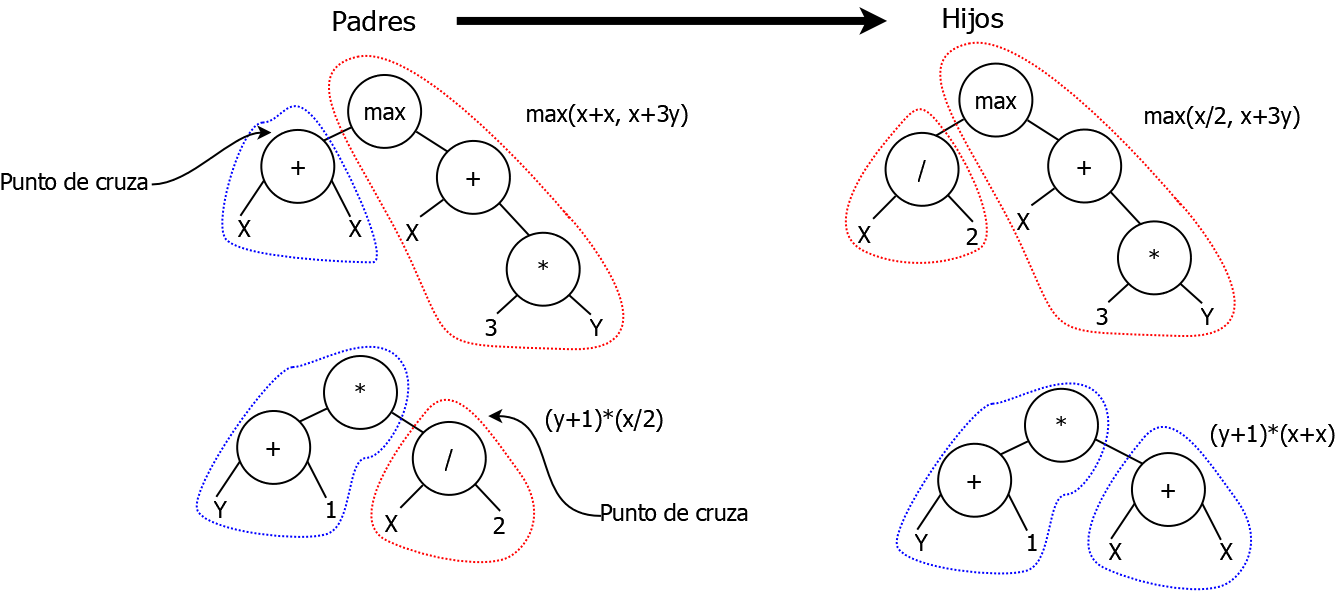

In [ ]:
toolbox.register("mate", gp.cxOnePoint)

A continuación se muestra un ejemplo de aplicar los operadores de cruza y mutación. Primeramente se generan dos individuos aleatoriamente que fungirán como padres, *ind1* e *ind2*. La instrucción *toolbox.mate(ind1,ind2)* genera un par de individuos, *off1_cx* y *off2_cx*, producto del operador de cruza.

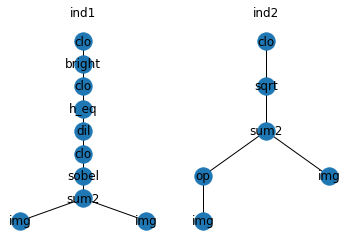

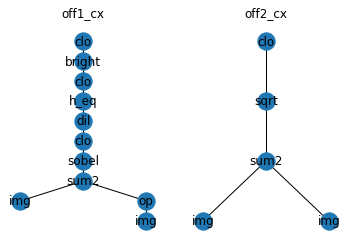

In [ ]:
ind1 = toolbox.individual()
ind2 = toolbox.individual()
plt_ind([ind1, ind2], ['ind1', 'ind2'])
off1, off2 = toolbox.mate(ind1, ind2)
plt_ind([off1, off2], ['off1_cx','off2_cx'])

### Mutación
La mutación más popular en PG es la **mutación uniforme**, que seleccióna un punto aleatorio en un arbol para descartar el subárbol generado y sustituirlo por otro generado aleatoriamente. En DEAP dicho operador se encuentra al invocar la función *gp.mutUniform* que toma como entrada un individuo y devuelve el individuo mutado como una 1-tupla.

La celda siguiente añade estos operadores al *toolbox.*

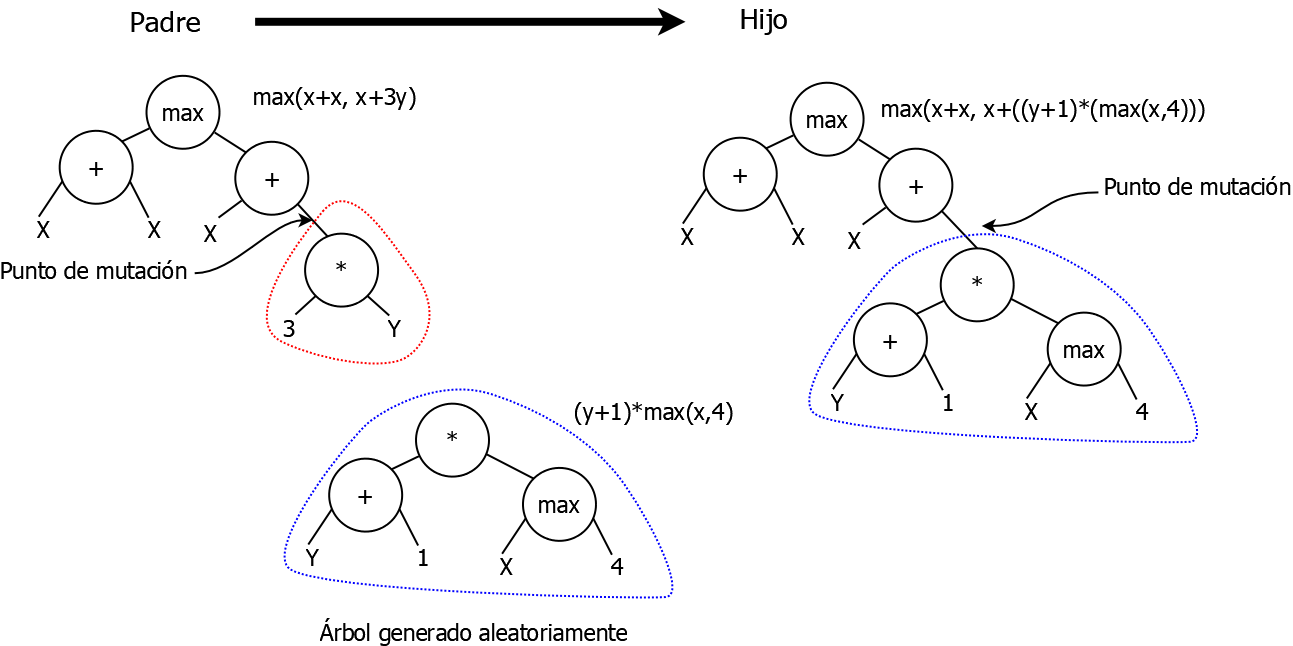

In [ ]:
toolbox.register("expr_mut", gp.genFull, min_=2, max_=10)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

La instrucción *toolbox.mutate(ind1)* genera al individuo *off_mut*, producto de mutar a *ind3*, generado aleatoriamente

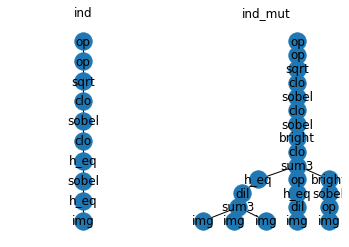

In [ ]:
ind3 = toolbox.individual()
off3, = toolbox.mutate(toolbox.clone(ind3))
plt_ind([ind3, off3], ['ind','ind_mut'])

## Control de altura de árboles
Las siguientes instrucciones permiten establecer un límite en los árboles generados por los operadores de cruza y mutación, de modo que si se escede determinada cota se selecciona aleatoriamente uno de los padres. Es importante observar que podemos considerar cualquier otro atributo de los individuos como cota máxima. De acuerdo con Jhon Koza, se recomienda un valor como cota máxima de 17.

In [ ]:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

## Función de evaluación
La función de evaluación o función de aptitud es la que permite responder a la pregunta ¿qué tan buena es la solución?, es decir, es una medida de calidad de las soluciones.

Consiste en aplicar la extracción de características dado por el árbol sintáctico para que estas sirvan como entradas de un modelo de clasificación. La tasa de clasificación o accuracy del modelo al ser evaluado en el conjunto de validación es considerado como la aptitud del individuo.

Para obtener una función invocable se hace uso de la instrucción gp.compile, la cual se encapsulta en la función compile al añadirse al toolbox. Por otro lado, las características obtenidas deberán representarse como un vector al considerarse como entradas del clasificador.

Los clasificadores considerados son: K-NN, árbol de decisión, Multiperceptrón y Máquina de Soporte Vectorial. Dichos clasificadores son tomados de las bibliotecas de Pytorch y Sklearn.

La siguiente figura ilustra el proceso que ocurre durtante la evaluación de los individuos.

La siguiente celda de código muestra cómo se implementa la función de evaluación, la cual se añade al toolbox de PG.

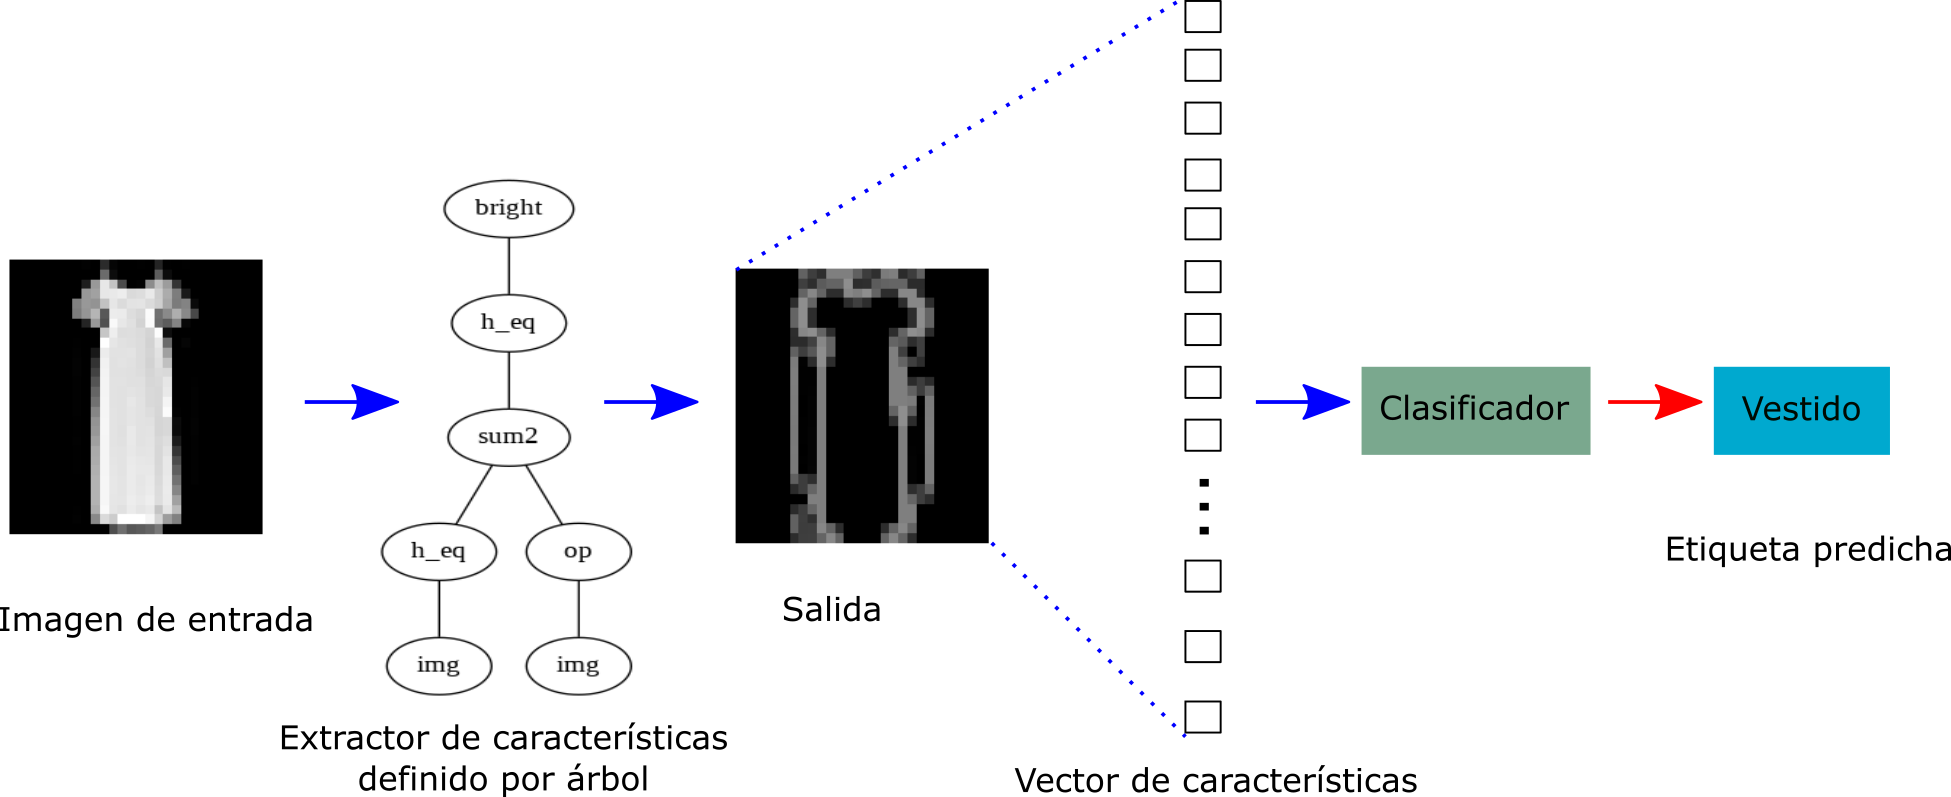

In [ ]:
def train(clf, inputs, labels):
  if isinstance(clf, (KNeighborsClassifier, MLPClassifier, DecisionTreeClassifier, SVC)):
    inputs = inputs.to("cpu")
    labels = labels.to("cpu")
    clf.fit(inputs, labels)

  elif isinstance(clf, nn.Module):
    #Optimizador y función de costo para entrenar el modelo MLP
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr=clf.lr)
    device = "cuda:0"
    clf = clf.to(device)
    clf.train()
    inputs = inputs.to(device)
    labels = labels.to(device)

    losses = []
    for i in range(clf.no_epochs):
      preds = clf(inputs)
      # preds = preds.to(device)
      loss = loss_fn(preds.to(device), labels)
      losses.append(loss)
      # print(f'Epoca: {i:2}  loss: {loss.item():10.8f}')
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    del preds
    # del inputs
    # del labels
    del optimizer
    torch.cuda.empty_cache()

  return clf

def validate(clf, inputs, labels, bandera):
  if isinstance(clf, (KNeighborsClassifier, MLPClassifier, DecisionTreeClassifier, SVC)):
    inputs = inputs.to("cpu")
    labels = labels.to("cpu")
    predicciones = clf.predict(inputs)
    predicciones=np.asarray(predicciones)
    labels = np.asarray(labels)
    matriz=confusion_matrix(labels,predicciones)
    score = accuracy_score(labels, predicciones)
    if bandera==True:
      df_plot=pd.DataFrame(matriz,index=['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle-boot'],
                           columns = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle-boot'])
      plt.figure(figsize=(8,6))
      sns.heatmap(df_plot, annot=True)
      plt.title('Matriz de confusión')
      plt.ylabel('Reales')
      plt.xlabel('Predicciones')
      plt.show()
    return clf.score(inputs,labels)

  elif isinstance(clf, nn.Module):
    # clf.eval()
    predicciones=[]
    device = "cuda:0"
    with torch.no_grad():
      clf=clf.to(device)
      inputs=inputs.to(device)
      labels=labels.to(device)

      for val in inputs:
          pred = clf.forward(val)
          predicciones.append(pred.argmax().item())

    inputs = inputs.to("cpu")
    labels = labels.to("cpu")
    clf = clf.to("cpu")

    df = pd.DataFrame({'Label': labels, 'Pred': predicciones})
    df['Correcto'] = ["Si" if corr == predicciones else "No" for corr, predicciones in zip(df['Label'], df['Pred'])]
    
    predicciones=np.asarray(predicciones)
    labels = np.asarray(labels)
    matriz=confusion_matrix(labels,predicciones)
    score = accuracy_score(labels, predicciones)
    # Bandera de activación para mostrar la matriz de confusión en caso de que se evalúe el mejor individuo tras realizar
    # de manera completa el proceso evolutivo.
    if bandera==True:
      df_plot=pd.DataFrame(matriz,index=['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle-boot'],
                           columns = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle-boot'])
      plt.figure(figsize=(8,6))
      sns.heatmap(df_plot, annot=True)
      plt.title('Matriz de confusión')
      plt.ylabel('Reales')
      plt.xlabel('Predicciones')
      plt.show()


    del predicciones
    del inputs
    del labels
    torch.cuda.empty_cache()

    return score

def evaluate(ind, clf_name="Neural Net", bandera=False):
  # print('Evaluation', ind)
  
  # print('Images', train_images.max(), train_images.min(), test_images.max(), test_images.min())
  function = toolbox.compile(ind)
  train_features = function(train_images)
  test_features = function(test_images)

  # print('Features', train_features.max(), train_features.min(), test_features.max(), test_features.min())

  #Convierte cada imagen  del conjunto de entrenamiento y prueba en un vector de entradas al modelo
  train_features = train_features.flatten(start_dim=1)
  test_features = test_features.flatten(start_dim=1)

  #Selecciona el modelo de clasificación
  if clf_name=="KNN":
    clf = clfs_names[clf_name]
  elif clf_name=="Decision Tree":
    clf = clfs_names[clf_name]
  elif clf_name=="MLP":
    clf = clfs_names[clf_name]
  elif clf_name == "SVM":
    clf = clfs_names[clf_name]
  else:
    print("Clasificador no seleccionado")

  #Entrena modelo de clasificación
  clf = train(clf, train_features, train_labels)
  #print("Estatus bandera: ",bandera)
  #Valida modelo de clasificación
  score = validate(clf, test_features, test_labels,bandera)

  return score,

toolbox.register("compile", gp.compile, pset=pset)

# toolbox.register("evaluate", evaluate, clf_name="KNN")
# toolbox.register("evaluate", evaluate, clf_name="Decision Tree")
# toolbox.register("evaluate", evaluate, clf_name="MLP")
toolbox.register("evaluate", evaluate,clf_name="SVM",bandera=False)

## Estadísticas del proceso evolutivo
La librería DEAP ofrece la clase *tools.Statistics* para llevar un seguimiento más detallado del proceso evolutivo. Recibe como argumento una función que pertime obtener los atributos de cada uno de los individuos con los que se generan las estadísticas de interés. Éstas son añadidas de forma similar al objeto *toolbox*. En este caso se considera obtener la media, máximo, mínimo y desviación estándar de la aptitud y tamaño de los individuos de la población. 

In [ ]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

## Parámetros del proceso evolutivo
Los parámetros considerados para el algoritmo evolutivo son los siguientes

*   Tamaño de población
*   Número de generaciones
*   Probabilidad de cruza
*   Probabilidad de mutación
*   Tasa de elitismo

El objeto *halloffame* lo proveé DEAP en el módulo *tools* que permite almacenar un determinado número de individuos de forma ordenada de acuerdo a su aptitud.

In [ ]:
tam_pob=120
population = toolbox.population(n=tam_pob)
halloffame = tools.HallOfFame(1)
verbose = True
ngen = 20
cxpb=0.9
mutpb=0.5
elitp=0.01

## Algoritmo evolutivo basado en PG con elitismo
A continuación se muestra el algoritmo implementado.


*   La función *variation()* permite aplicar los operadores de variación almacenados en el objeto *toolbox* al conjuto de padres que recibe como parámetro. 
*   La función *eaElitism()* es la función principal del algoritmo evolutivo. Recibe los objetos *mstats* y *toolbox* antes declarados que permiten obtener las estadísticas y aplicar las operaciones del proceso evolutivo, respectivamente. El objeto *halloffame* es actualizado en cada generación. Dentro de la función se genera el objeto *logbook* que permite generar registros cronológicos de la evolución.


In [ ]:
def variation(parents, toolbox, cxpb, mutpb):
  #Duplica conjunto de padres
  offspring = [toolbox.clone(ind) for ind in parents]

  # Aplica cruza y mutación
  for i in range(1, len(offspring), 2):
      if random.random() < cxpb:
          offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                        offspring[i])
          del offspring[i - 1].fitness.values, offspring[i].fitness.values

  for i in range(len(offspring)):
      if random.random() < mutpb:
          offspring[i], = toolbox.mutate(offspring[i])
          del offspring[i].fitness.values

  return offspring

def eaElitism(population, toolbox, cxpb, mutpb, elitpb, ngen,
              stats, halloffame, verbose):
  
  #Genera objeto logbok
  logbook = tools.Logbook()
  logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

  # Evalúa los individuos que no tienen asignado el atributo "fitness"
  invalid_ind = [ind for ind in population if not ind.fitness.valid]
  fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
  for ind, fit in zip(invalid_ind, fitnesses):
      ind.fitness.values = fit
  
  #Se seleccionan los mejores individuos de la población para conservarlos en la siguiente generación
  inds_elit = tools.selBest(population, int(elitpb*tam_pob))

  if halloffame is not None:
      halloffame.update(population)

  record = stats.compile(population) if stats else {}
  logbook.record(gen=0, nevals=len(invalid_ind), **record)
  if verbose:
      print(logbook.stream)

  #Comienza proceso generacional
  for gen in range(1, ngen + 1):
      # Selecciona los padres para generar la descendencia
      parents = toolbox.select(population, len(population)-int(elitpb*tam_pob))

      # Se aplican los operadores de variación
      offspring = variation(parents, toolbox, cxpb, mutpb)

      # Evalúa los individuos que no tienen asignado el atributo "fitness"
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit

      # Añade a la descendencia los individuos seleccionados por elitismo
      offspring = offspring + inds_elit

      # Actualiza salón de la fama con población generada
      if halloffame is not None:
          halloffame.update(offspring)

      # Remplaza la población con los individuos de la descendencia
      population[:] = offspring

      # Añade las estadísticas de la generación al objeto "Logbook"
      record = stats.compile(population) if stats else {}
      logbook.record(gen=gen, nevals=len(invalid_ind), **record)
      if verbose:
          print(logbook.stream)
      
      # Actualiza los individuos seleccionados por elitismo
      inds_elit = tools.selBest(population, int(elitpb*tam_pob))

  return population, logbook

population, logbook = eaElitism(population, toolbox, cxpb, mutpb, elitp, ngen,
                                mstats, halloffame, verbose)

   	      	                        fitness                         	                      size                     
   	      	--------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max  	min	nevals	std     	avg    	gen	max 	min	nevals	std    
0  	120   	0.587417	0  	0.805	0.1	120   	0.257572	86.7083	0  	1559	4  	120   	194.261
1  	114   	0.700333	1  	0.805	0.1	114   	0.144673	26.5917	1  	238 	2  	114   	33.3645
2  	112   	0.727667	2  	0.82 	0.1	112   	0.123293	21.9   	2  	164 	2  	112   	24.0705
3  	110   	0.713667	3  	0.82 	0.1	110   	0.164543	20.25  	3  	233 	2  	110   	26.7262
4  	113   	0.744417	4  	0.82 	0.1	113   	0.100568	21.6417	4  	165 	2  	113   	24.1484
5  	110   	0.734   	5  	0.82 	0.1	110   	0.138425	19.925 	5  	130 	2  	110   	20.0346
6  	114   	0.759458	6  	0.825	0.1	114   	0.0732541	17.2   	6  	86  	2  	114   	13.4311
7  	114   	0.735833	7  	0.825	0.1	114   	0.126835 	22.775 	7  	283 	2  	114   	

## Gráfica de convergencia

Se genera una función que permite graficar y almacenar como archivo *.png* el comportamiento evolutivo con base en la información almacenada en el objeto *logbook*.

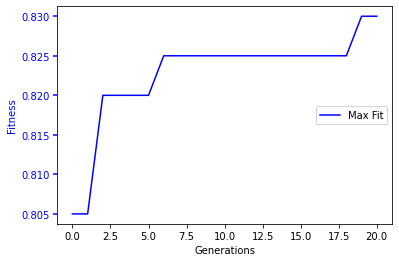

In [ ]:
def convergence_graph(logbook, name):
  gen=logbook.select("gen")
  fit_max=logbook.chapters["fitness"].select("max")
  fig, host = plt.subplots()
  p1, = host.plot(gen, fit_max, "b-", label="Max Fit")
  host.set_xlabel("Generations")
  host.set_ylabel("Fitness")
  host.yaxis.label.set_color(p1.get_color())
  tkw = dict(size=4, width=1.5)
  host.tick_params(axis='y', colors=p1.get_color(), **tkw)
  lines = [p1]
  
  host.legend(lines, [l.get_label() for l in lines], loc="center right")
  # fig.savefig(ruta+"/Convergencia.png")
  fig.savefig("./"+name)
  # plt.close(fig)
  plt.show()

convergence_graph(logbook, "GraficaConvergencia")

Finalmente se muestra el mejor individuo y su aptitud

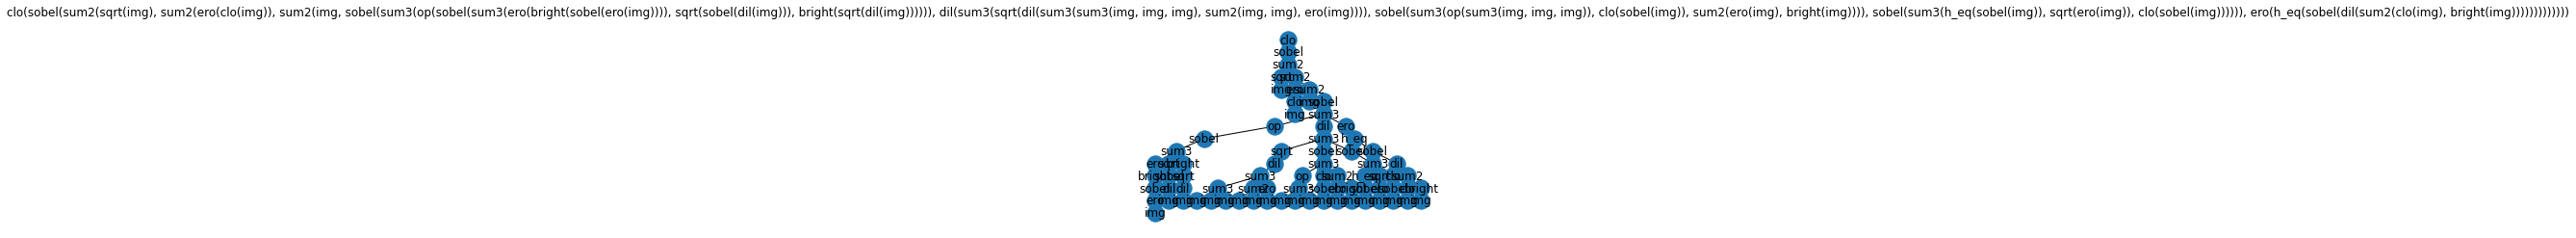

Aptitud del mejor individuo:  (0.83,)


In [ ]:
best=tools.selBest(population, 1)[0]
plt_ind([best], [str(best)])
save_ind(best, "Best_Individual")
print("Aptitud del mejor individuo: ",best.fitness.values)

## Visualización de la característica construida a partir del mejor individuo

Finalmente, se muestra un ejemplo de la caracterísica generada para una imagen en particular

clo(sobel(sum2(sqrt(img), sum2(ero(clo(img)), sum2(img, sobel(sum3(op(sobel(sum3(ero(bright(sobel(ero(img)))), sqrt(sobel(dil(img))), bright(sqrt(dil(img)))))), dil(sum3(sqrt(dil(sum3(sum3(img, img, img), sum2(img, img), ero(img)))), sobel(sum3(op(sum3(img, img, img)), clo(sobel(img)), sum2(ero(img), bright(img)))), sobel(sum3(h_eq(sobel(img)), sqrt(ero(img)), clo(sobel(img)))))), ero(h_eq(sobel(dil(sum2(clo(img), bright(img)))))))))))))


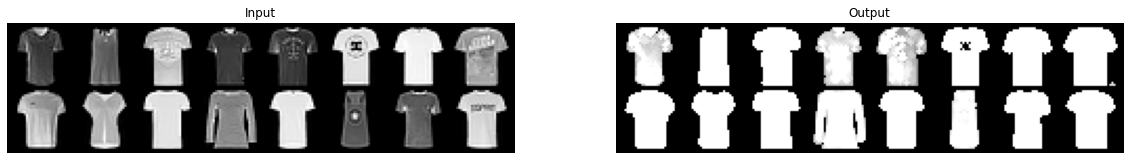

In [ ]:
function = toolbox.compile(best)
train_features = function(train_images)
inp_out=[train_images, out]
idx=16
grids=[torchvision.utils.make_grid(io[:idx], nrow = idx//2, padding = 2) for io in inp_out]
grids=[np.transpose(grid.numpy(), (1,2,0)) for grid in grids]
titles=['Input', 'Output']

f = plt.figure(figsize=(20,20))
for i in range(len(titles)):
  f.add_subplot(1, len(titles), i+1)
  plt.axis('off')
  plt.title(titles[i])
  plt.imshow(grids[i])
print(str(best))

## Matriz de confusión
Se obtienen las predicciones del clasificador con el objetivo de mostrar la matriz de confusión.
Es decir, se muestran los errores y aciertos al momento de asignar etiquetas al conjunto de imágenes. 


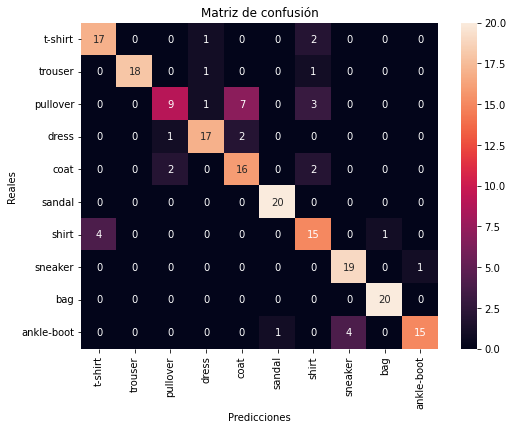

(0.83,)

In [ ]:
evaluate(best,clf_name="SVM",bandera=True)

# Referencias


1.   O’Neill, M. (2009). Riccardo Poli, William B. Langdon, Nicholas F. McPhee: a field guide to genetic programming.
2.  Koza, J. R. (1994). Genetic programming II (Vol. 17). Cambridge: MIT press.
3. https://github.com/kornia/kornia
4. https://github.com/DEAP/deap
5. https://github.com/Happy-Algorithms-League/hal-cgp
